# Linear regression, part 2

In this notebook we expand on the ideas of linear regression as we try to resolve problems we encounter when we try to fit a regression model. More specifically, we talk about how to include categorical data in our model, how to deal with high multi-collinearity between features, and finally what to do if the response variable is binary. Although these topics are not necessarily related to each other, they are all good examples of how we can extend the ideas behind linear regression to address its shortcomings.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 7]
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as statsmodels
import statsmodels.formula.api as sm
from patsy import dmatrix

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Encoding categorical features

It's time to talk about what to do with categorical features. Recall that after expressing the math of linear regression using linear algebra, $\pmb{X}$ ends up being a matrix with a column of 1s as its first column to account for the intercept. So we need to encode our categorical features as numeric columns that we can include in $\pmb{X}$. It turns out that we have more than one option, although most of the time we get go with the default option. Let's read in our data and learn by example:

In [ ]:
hsb2 = pd.read_csv('../data/hsb2.csv')
hsb2.head()

In [ ]:
hsb2.info()

### Exercise

Notice that we have a few categorical features we can use in the data, however in this case the categorical features are already encoded as numbers. For example `schtype == 1` means "public" and `schtype == 0` means "private". So what's stopping us from using these as is?

- Using `sm.ols` train a model to predict writing score using reading score and socio-economic status (column named `ses`). Then examine the results by calling the fitted model's `summary2()` method.

In [ ]:
## your code goes here

- Is the coefficient for `ses` significant? Write your best interpretation of it based on what we learned so far. Do you see any problems with the interpretation?

To encode a variable as categorical we wrap its name with a `C` function in the formula, e.g. `y ~ x + C(v)` if `v` is categorical. 

- Fit a new model this time encoding `ses` as categorical. What changes in the results table? Write the prediction equation.

In [ ]:
## your code goes here

When we encode a variable as categorical, by default it creates a separate coefficient for all its categories except the first one. The first category becomes what we call **the baseline**, and the coefficients for each of the other categories capture the average "effect" of moving from the baseline to that category. So in the results above we can see that the coefficient for `C(ses)[T.2]` is -0.4746. This means that on average students with `ses == 2` have a score of 0.4746 less than the `ses == 1` (baseline) students. For an **orginal** categorical column like `ses`, both ways of fitting the model are valid, although the first way is more constrained. For **nominal** categorical columns like `race` or `gender`, only the second way is valid.

- Recode the `ses` column using proper names: low, middle and high:

In [ ]:
## your code goes here

Notice that now the first category is `high`, whereas before it was `1` (which corresponds to `low`). This is because when we alphabetically sort the catogories by their new names, `high` appears first, whereas before `1` appeared first.

- Refit the same model now that `ses` has been recoded. What differences do you see?

In [ ]:
## your code goes here

Foretunately, there's an easy way to choose which category to use as the **baseline**.

- Refit the same model, but use this as `formula = "write ~ read + C(ses, Treatment(reference = 'low'))"`. Do the results make sense?

In [ ]:
## your code goes here

The type of coding shown above is called **dummy coding** (because it's what we get if we encode each category except the baseline using **dummy variables**). This is the most common type of encoding and the default one used by most statistical packages for regression models (linear regression, ANOVA, logistic regression, etc.). In machine learning, **dummy coding** is more commonly known as **one-hot encoding**, however in the latter case we usually do not drop any of the columns. Not dropping the baseline column can cause issues with convergence of the regression model, but this is only caused if there's no regularization, so in practice one-hot encoding the feature is fine.

In [ ]:
data = hsb2.loc[~hsb2.duplicated(subset = 'ses'), :].sort_values(['ses'])
dmatrix("C(ses, Treatment('low'))", data, return_type = "dataframe")

There are other coding schemes that we can use (more on this topic [here](https://patsy.readthedocs.io/en/latest/API-reference.html#patsy.Treatment). Here's another one called deviation coding for example:

In [ ]:
dmatrix("C(ses, Sum)", data, return_type = "dataframe")

- Rerun the same model, but this time use deviation coding instead of dummy coding. What changes in the model summary? 

In [ ]:
## your code goes here

- Create a scatter plot of reading score (x-axis) vs writing score (y-axis). Then add a line plot of the prediction line for writing score (you will need to use your model to get predictions and add them as a new column to the data). Color-code the line plot by `hue = 'ses'` se we get a separate line plot for each value of `ses`.

In [ ]:
## your code goes here

- Fit a new model now that also includes the interaction between `read` and `C(ses)`. Examine the model summary and report what changed. Then recreate the scatter plot with the prediction lines above. What looks different now? Can you interpret each of the coefficients based on the line plots?

In [ ]:
## your code goes here

And voila! This was a long exercise but the goal was to slowly build our way up. There are other things we can test. For example, how does changing the encoding change the prediction? The answer is that it doesn't. Changing the encoding changes the coefficients and their interpretation, but those new coefficients still return the same prediction. What about including more than one categorical feature? What about the interaction of two categorical features? We leave it to you to try this and based on what you learned in this exercise you should be able to make a good guess as to what to expect.

### End of exercise

As you saw in the example above, when we have categorical features in a model, we have some flexibility in how we want them encoded, but the general idea is to have a separate coefficient for each **level** (grouping) of a categorical feature, and another coefficent for each combination of the interactions of two categorical features (assuming we fit a model with interactions). Different choices for the **encoding** of the categorical features leads to different interpretations of their coefficients, but ultimately all lead to the same prediction. You can imagine that having **high-cardinality** categorical features can cause the model to quickly grow in complexity (number of coefficients), even when no interactions are being considered. In such cases, one option is to use **feature hashing**, which allows us to trade-off the size of the encoding with the risk of collision.

## Logistic Regression

Until now, we have been working strictly with linear **regression models**, which assumes that we have a numeric target. With a slight modification of linear regression, we can also predict binary targets (`{False, True}` or `{0, 1}` etc.). The result is called **logistic regression**. As mentioned earlier, the word "regression" in logistic regression refers to its relationship to linear regression, but logistic regression is a classification algorithm.

The response of the linear model is transformed to the log odds-ratio using a sigmoidal function, also known as the **logistic map** or the **sigmoid function**:

$$f(x | x_0, \kappa) = \frac{1}{1 + e^{-\kappa(x - x_0)}}$$

where $\kappa$ is a measure of the steepness of the curve, as you can see here:

In [ ]:
# Plot the logistic transformation function (f(x) above)
x_seq = np.linspace(-7, 7, 100)

def log_fun(x, center = 0, scale = 1):
    e = np.exp(-scale*(x - center))
    log_out = 1./(1. + e)
    return log_out

log_fun_vectorized = np.vectorize(log_fun)

for ii in range(10):
    log_y = log_fun_vectorized(x_seq, scale = ii)
    sns.lineplot(x_seq, log_y, alpha = 1.0/(ii + 1), color = 'blue');
    
plt.xlabel('x')
plt.ylabel('logistic(x)');
plt.legend(['kappa = ' + str(ii) for ii in range(10)]);

Let's make this a bit more concrete with a simple example. Say we have a linear model:

$$\hat{Y} = b_0 + b_1 X$$

Now, depending on the value of $\hat{Y}$ we want to classify the output from a logistic regression model as either `0` or `1`. We can use the linear model in the logistic function as follows:

$$f(\hat Y|X) = f(b_0 + b_1 X) = \frac{1}{1 + e^{-\kappa(b_0 + b_1 X)}}$$

We can ignore $\kappa$ since it can be factored into the coefficients. In this way we transform the continuous output of the linear model defined on $-\infty \le \hat Y \le \infty$ to a binary response, $0 < f(\hat Y|X) < 1$. If we do the transformation in reverse we get

$$e^{-(b_0 + b_1 X)} = \frac{1}{f(\hat Y|X)} - 1 = \frac{1 - f(\hat Y|X)}{f(\hat Y|X)} \quad\Rightarrow\quad b_0 + b_1 X = \log(\frac{f(\hat Y|X)}{1 - f(\hat Y|X)})$$

The right-hand side shows the relationship between linear and logistic regression: Logistic regression is what we get if we have a binary response variable and run linear regression, not to predict $Y$ directly, but to predict a transformation of $Y$.

What about interpreting our results? First note that because of the nature of the logistic map, we can think of $f(\hat Y|X)$ as a probability: $f(\hat Y|X) = P(Y = 1|X)$. This means we can rewrite the right-hand side of the above equation as 

$$b_0 + b_1 X = \log(\frac{f(\hat Y|X)}{1 - f(\hat Y|X)}) = \log(\frac{P(Y = 1|X)}{P(Y = 0|X)})$$

We call the ratio $P(Y = 1) / P(Y = 0)$ the **odds ratio**, and so the quantity on the right-hand side of the above equation is called the **log odds-ratio**.

To summarize, when we have a binary response variable $Y \in \{0, 1\}$, logistic regression fits a linear regression model to predict the log odds-ratio of $Y = 1$ using our features. Once we have the prediction, we can express it as a probability $P(Y = 1 | X)$ by rewriting it:

$$P(Y = 1|X) = \frac{1}{1 + e^{-(b_0 + b_1 X)}}$$

We can easily extend this idea to many features and nothing really changes other than having additional terms in the exponential term.

Unlike linear regression, we do NOT have a **closed-form solution** in logistic regression. So we find the coefficients $b_i$ using optimization. The function we optimize is the likelihood given by 

$$L(\pmb{\beta}) = \prod_j P(Y_j = 1|X_j)^{Y_j} \times (1 - P(Y_j = 1|X_j))^{1 - Y_j}$$

although computationally it is easier to optimize the log of the likelihood, conviniently called the **log-likelihood**.

### Exercise

We learned how to extend linear regression for dealing with various situations. As you can see, linear regression gives us a very flexible building block. For this reason, many other algorithms build on the same ideas introduced in linear regression. We also saw how the coefficients in linear regression lend themselves to a simple interpretation, and how more complex models make this interpretation harder to maintain. In this assignment, we will learn how to train and work with  logistic regression models, which are a relatively simple modification of linear regression so we can do classification.

Let's re-load the HSB2 data and use it to illustrate logistic regression.

In [ ]:
hsb2 = pd.read_csv('../data/hsb2.csv')
hsb2.head()

- Create a new column called `math_high` that is equal to 1 when a student's math score is above the 80% percentile, and 0 otherwise.

In [ ]:
## your code goes here

- Can a student's science score and the school type they attended be good predictors of a student's probability of being in the top 20% in math? For school type we use the column `schtyp`, where `1` is public and `2` is private school. HINT: Use `sm.logit` to train a logistic regression. You can pass it a formula just like the one in linear regression.

In [ ]:
## your code goes here

- Print a summary of the model you fit. What are important information about the model worth reporting?

In [ ]:
## your code goes here

- Here are the model's parameters. Based on what you know about interpreting model parameters in linear regression, how would you interpret the model parameters for the logistic regression model? HINT: It's a little more relatable to try to interpret $e^{b_i}$ instead of $b_i$ itself, using `np.exp`.

In [ ]:
## your code goes here

To visualize how $P(Y = 1)$ changes with the science score for different school types, we can simulate a data with combinations of science scores and school types and predict for it.

In [ ]:
x = np.linspace(20, 120, 100)
y = [1, 2]
X = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
sim_data = pd.DataFrame(X, columns = ['science', 'schtyp'])
sim_data.head()

- Predict $P(Y = 1)$ for the above data and add it as a new column called `prob_math_high`. Then replace school type values with their proper labels `{1: 'public', 2: 'private'}`.

In [ ]:
## your code goes here

- Create a line plot of `P(Y = 1)` against `science`, color-coded by `schtyp`.

In [ ]:
## your code goes here

The above predictions are what we call **soft predictions** because they are probabilities, as opposed to **hard predictions** which are `True, False` or `1, 0` predictions. To get the hard predictions, we first need to set a threshold $q \in (0, 1)$ and predict

$$
\begin{equation*}
\hat Y = \begin{cases}
             0  & \text{if } P(Y = 1) < q \\
             1  & \text{if } P(Y = 1) \ge q
     \end{cases} \quad
\end{equation*}
$$

Therefore hard predictions depend on the choice of the threshold $q$. All subsequent measures that are calculated from hard predictions (TP, TN, FP, FN, precision and recall, etc.) also depend on $q$.

- Use the model's `pred_table` method to get the **confusion matrix**. By default, this is based on $q = 0.50$ but change the value of $q$ to $0.30$. What is the precision and recall of this model?

In [ ]:
## your code goes here

- Calculate the sensitivity and specificity of the test. Sensitivity and specificity are two measures that are used to evaluate a binary classifier. We define **sensitivity** as $\frac{TP}{FN + TP}$ and **specificity** as $\frac{TN}{FP + TN}$.

In [ ]:
## your code goes here

We can see in the below cell the relationship between the $q$ and sensitivity or specificity.

In [ ]:
res = pd.DataFrame({'q': np.linspace(0, 1, num = 50)})
res['precision'] = 0
res['recall'] = 0
epsilon = 0.0001

for index, row in res.iterrows():
    cm = logit_model.pred_table(threshold = row['q'])
    res.loc[index, 'specificity'] = cm[0, 0] / (cm[0, :].sum() + epsilon)
    res.loc[index, 'sensitivity'] = cm[1, 1] / (cm[1, :].sum() + epsilon)

sns.lineplot('q', 'sensitivity', data = res, color = 'blue')
sns.lineplot('q', 'specificity', data = res, color = 'red')
plt.legend(['senstivity', 'specificity']);

- Explain why sensitivity drops as $q$ increases while specificity increases.

There are other ways to evaluate binary classification models, such as precision and recall. Sensitivity and specificity is more common in the medical field while precision and recall come from information retrieval. Recall and sensitivity have the same definition, but precision and specificity are not the same thing and should not be confused.

### End of exercise

# Assignment


In this assignment, we will learn to use polynomial splines for estimating the relationship between features and a target. Generalized additive models are based on very similar methods, but to avoid getting into too much detail we try to expose you to some basic ideas behind GLMs.

Let's load our libraries first.

In [28]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 7]

from patsy import dmatrix, bs
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as statsmodels
import statsmodels.formula.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Let's turn to the `auto-price.csv` data: we will use try to use `horsepower` to predict `highway-mpg`. Here's what the scatter plot of the two looks like.

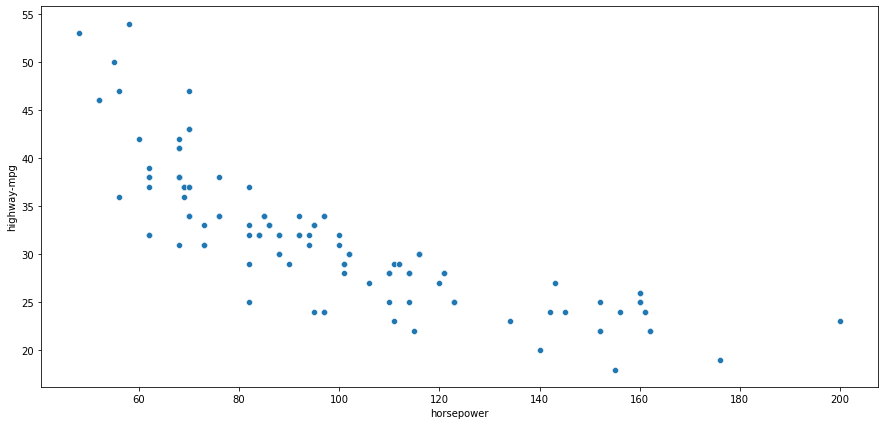

In [29]:
auto = pd.read_csv('../data/auto-price.csv', na_values = '?')
auto = auto.dropna()
sns.scatterplot(x = 'horsepower', y = 'highway-mpg', data = auto);

#Remember to rename highway-mpg

As we can see, the relationship is not linear, but curvelinear. We already know how to model this type of data: We can use polynomial regression. 

- Fit a polynomial regression to predict `highway-mpg` using `horsepower`. You will need to choose a degree and justify your choice. Recreate the above scatter plot and add the predicitons from the model to the plot (use `sns.lineplot`). <span style="color:red" float:right>[10 point]</span>

In [30]:
y_data = auto['highway-mpg']
x_data = auto['horsepower']

x_array=x_data.to_numpy()
y_array=y_data.to_numpy()

x=x_array.reshape(-1,1)
y=y_array.reshape(-1,1)



#y_ser = y_data.reshape(-1,1)

#x=x_ser.to_numpy()
#y=y_ser.to_numpy()

In [11]:
len(y)

159

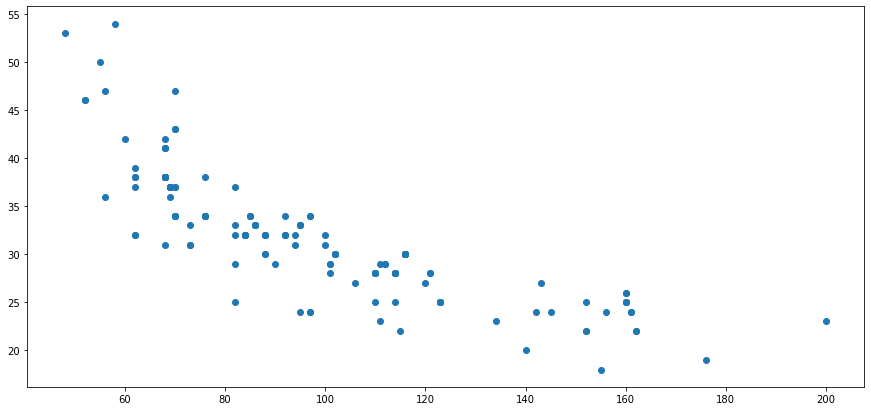

In [31]:
plt.scatter(x,y);

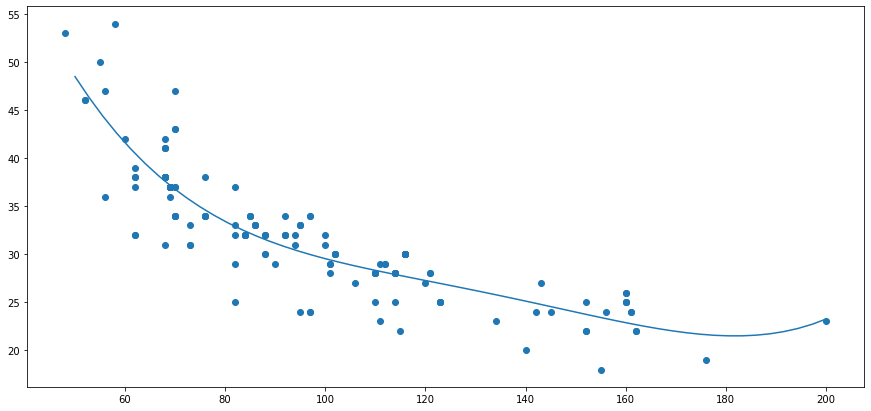

In [37]:
mymodel=np.poly1d(np.polyfit(x_data,y_data,4))
myline=np.linspace(50,200,55)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.show()
#Make sure to add labels
#Take a look into AIC Curve as well here for goodness of fit; 4 may have a lower AIC score as well
#Add an explanation

Let's now compare the polynomial model to the splines. To see how splines work, we will build one manually. To do so, we are going to define $B_j(X) = (X - T_j)^l$ whenever $X > T_j$ and $B_j(X) = 0$ otherwise. So first we choose some positive integer $l$, then we choose a set of $k$ points $T_1, \ldots, T_k$ we call **knots**, and for each of them, we create a feature $B_j(X)$.

- Let $l = 0$ for now. Construct the features `B_1`, `B_2` and `B_3` using the knots 80, 120, 160 respectively. Then train a linear model to predict `highway-mpg` using `horsepower`, `B_1`, `B_2` and `B_3`. Print the model's coefficients, and once again plot the scatter plot of  `highway-mpg` against `horsepower` and put the prediction curve on the line. How would you describe the predictions? <span style="color:red" float:right>[10 point]</span>

In [26]:
l = 0 # the exponent
# create features B1, B2, B3 as described above
auto.loc[(x_data>80, 'B_1')] = (x-80)**l
auto.loc[(x_data>120, 'B_2')] = (x-120)**l
auto.loc[(x_data>160, 'B_3')] = (x-160)**l
#values = {"B_1":0, "B_2":0, "B_3":0}
#auto = auto.fillna(value=values)


# train a model using horsepower and the features created above
ols_model = sm.ols(formula = "y ~ x + B_1 + B_2 + B_3", data = auto).fit()
auto['highwaympg2']=ols_model.predict(auto)
# print coefficients
ols_model = sm.ols(formula = "write ~ read * C(ses)", data = hsb2).fit()
hsb2['write_pred'] = ols_model.predict(hsb2)
# hsb2.head()
# ols_model.summary2()


# plot scatter plot and prediction curve
sns.scatterplot(x = 'read', y = 'write', data = hsb2)
sns.lineplot(x = 'read', y = 'write_pred', data = hsb2)

ValueError: cannot set using a multi-index selection indexer with a different length than the value

- Now rerun your code (in a new cell below) but this time use `l = 1` instead of `l = 0`. How would you describe the prediction curve? Repeat this with `l = 2` and `l = 3`. Which value of `l` do you think best fits the data? <span style="color:red" float:right>[10 point]</span>

In [ ]:
l = 1 # the exponent
# create features B1, B2, B3 as described above
auto.loc[(x_data>80, 'B_1')] = (x-80)**l
auto.loc[(x_data>120, 'B_2')] = (x-80)**l
auto.loc[(x_data>160, 'B_3')] = (x-80)**l
values = {"B_1":0, "B_2":0, "B_3":0}
auto = auto.fillna(value=values)


# train a model using horsepower and the features created above
x=[[]]

# print coefficients
ols_model = sm.ols(formula = "write ~ read * C(ses)", data = hsb2).fit()
hsb2['write_pred'] = ols_model.predict(hsb2)
# hsb2.head()
# ols_model.summary2()


# plot scatter plot and prediction curve
sns.scatterplot(x = 'read', y = 'write', data = hsb2)
sns.lineplot(x = 'read', y = 'write_pred', data = hsb2)

In [ ]:
l = 2 # the exponent
# create features B1, B2, B3 as described above
auto.loc[(x_data>80, 'B_1')] = (x-80)**l
auto.loc[(x_data>120, 'B_2')] = (x-80)**l
auto.loc[(x_data>160, 'B_3')] = (x-80)**l
values = {"B_1":0, "B_2":0, "B_3":0}
auto = auto.fillna(value=values)


# train a model using horsepower and the features created above
x=[[]]

# print coefficients
ols_model = sm.ols(formula = "write ~ read * C(ses)", data = hsb2).fit()
hsb2['write_pred'] = ols_model.predict(hsb2)
# hsb2.head()
# ols_model.summary2()


# plot scatter plot and prediction curve
sns.scatterplot(x = 'read', y = 'write', data = hsb2)
sns.lineplot(x = 'read', y = 'write_pred', data = hsb2)

In [ ]:
l = 3 # the exponent
# create features B1, B2, B3 as described above
auto.loc[(x_data>80, 'B_1')] = (x-80)**l
auto.loc[(x_data>120, 'B_2')] = (x-80)**l
auto.loc[(x_data>160, 'B_3')] = (x-80)**l
values = {"B_1":0, "B_2":0, "B_3":0}
auto = auto.fillna(value=values)


# train a model using horsepower and the features created above
x=[[]]

# print coefficients
ols_model = sm.ols(formula = "write ~ read * C(ses)", data = hsb2).fit()
hsb2['write_pred'] = ols_model.predict(hsb2)
# hsb2.head()
# ols_model.summary2()


# plot scatter plot and prediction curve
sns.scatterplot(x = 'read', y = 'write', data = hsb2)
sns.lineplot(x = 'read', y = 'write_pred', data = hsb2)

Creating all these features manually is clearly tedious. We did it this exercise to convince you that it's not that hard, but we will now turn to a package to make things easy. In the first line of the code below, you will see the knots and the exponent `l = 2` hard-coded in a string. We pass this string to the `dmatrix` function in the next line to featurized the data accordingly. Examine the resulting data (called the **design matrix**) with all the features created. The `bs` function stands for B-splines, which are very similar to our manual splines earlier.

In [27]:
sp_type = "bs(x, knots = (80, 120, 160), degree = 2, include_intercept = False)"
X_featurized = dmatrix(sp_type, {"x": auto['horsepower']}, return_type = 'dataframe')
X_featurized.describe()
#Difference of False)[0] signifies the difference of the l
#rename column names
#plot 75th% across all columns

,Intercept,"bs(x, knots=(80, 120, 160), degree=2, include_intercept=False)[0]","bs(x, knots=(80, 120, 160), degree=2, include_intercept=False)[1]","bs(x, knots=(80, 120, 160), degree=2, include_intercept=False)[2]","bs(x, knots=(80, 120, 160), degree=2, include_intercept=False)[3]","bs(x, knots=(80, 120, 160), degree=2, include_intercept=False)[4]"
count,159.0,159.000000,159.000000,159.000000,159.000000,159.000000
mean,1.0,0.323749,0.377466,0.168178,0.048795,0.007335
std,0.0,0.283173,0.261702,0.224931,0.141837,0.080231
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.012500,0.173611,0.000000,0.000000,0.000000
50%,1.0,0.272222,0.340278,0.020000,0.000000,0.000000
75%,1.0,0.662489,0.625347,0.361250,0.000000,0.000000
max,1.0,0.692274,0.736840,0.750000,0.660000,1.000000


As you can see below, the features created are not the same as the ones we created manually. That's because there is an additional constraint that $\sum_j B_j(X) = 1$ for all values of $X$. In other words, the $B_j$ features together add up to 1 at each row. You can read more about B-spline details [here](https://en.wikipedia.org/wiki/B-spline) if you wish, but we will not delve further into that here.

- What can you conclude judging from the percentiles in the above table. <span style="color:red" float:right>[5 point]</span>

So the `dmatrix` function took care of creating all the features for us. All that's left is to train a model similar to before but using these new features now.

- Fit a linear regression model to predict `highway-mpg` using the features returned by `bmatrix`. Plot the scatter plot and prediction curve. Return to change the `degree` to 0, then 1, then 2, then 3 and notice how the prediction line changes. Describe your findings. <span style="color:red" float:right>[10 point]</span>

In [ ]:
## your code goes here

With more than one feature, the basic idea is still the same, but to visualize results we can plot a separate plot for each feature $X_j$ agaist the prediction. Intuitively, we can say that every feature $X_j$ is transformed to many features (one for each basis function applied to it), and together all those transformed features are used to predict the target. Since we could end up with too many useless features at the end, we use some form of penalization like **L1-regularization** to do feature selection and avoid overfitting at the same time. So this simple yet powerful idea is what GAMs are based on.

# End of assignment